In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import os
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
from torch.nn.functional import softmax, cross_entropy, mse_loss
from torch.optim import Adam
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

# Set the precision to medium
torch.set_float32_matmul_precision("high")

import pytorch_lightning as pl

from customdataset import CustomDataset
from fullhand_model_lghtng import ResNet50
from torchvision.models import inception_v3, Inception_V3_Weights

from fullhand_model_inception_lghtng import Inception


/home/pranay/miniconda3/envs/cnn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pwd

'/home/pranay/segmental_GP'

In [3]:
# define path to the folder and csv file
img_folder_path = "./data/fh_val"
csv_file_path = "./data/val.csv"

# define transformations to be applied to images
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.14, 0.14, 0.14), (0.18, 0.18, 0.18))
    ]
)

# create instance of custom dataset
val_dataset = CustomDataset(img_folder_path, csv_file_path, transform=transform)

# create dataloader for the dataset
batch_size = 16

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=32
)

In [4]:
# show a batch of images
for batch_idx, (data, label) in enumerate(val_loader):
    # data shape: (batch_size, channels, height, width)
    # label shape: (batch_size, )

    # show the first image in the batch
#     print(data)
#     # print(data[1].dtype)
    img = data[0]
    img = transforms.ToPILImage()(img)
    img.show()

    # break out of loop after showing first batch of images
    break

In [5]:
# Load the saved model weights
# trained_model = ResNet50()
trained_model = Inception()
trained_model.load_state_dict(torch.load("fullhand_trainedmodel.pt"))

<All keys matched successfully>

In [6]:
from pytorch_lightning import Trainer
# Create a trainer with the required settings
trainer = Trainer(accelerator="gpu", devices=1)

# Make predictions on the new data
predictions = trainer.predict(trained_model, dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 30.25it/s]


In [7]:
predictions = torch.cat(predictions).numpy()
# get the labels from the validation dataset
val_labels = []
for _, labels in val_dataset:
    val_labels.append(labels)
val_array = np.array(val_labels, dtype=np.float32)

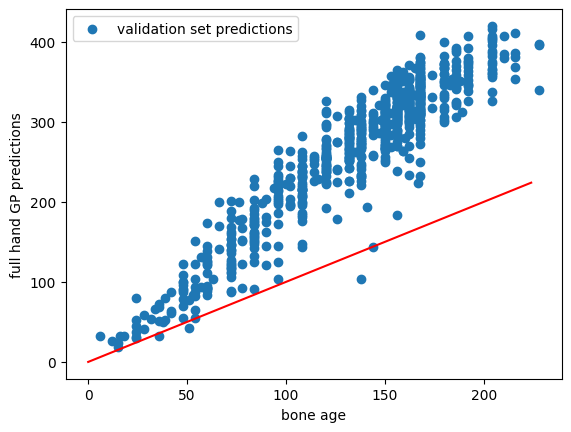

In [8]:
plt.scatter(val_array, predictions, label='validation set predictions')
# add a line to the plot
plt.plot([0, 224], [0, 224], color='red')
plt.xlabel('bone age')
plt.ylabel('full hand GP predictions')
plt.legend()
plt.show()

In [9]:
np.mean(np.abs(val_array-predictions.squeeze()))

132.3631

In [10]:
len(val_array)

773

In [11]:
len(predictions)

773

In [12]:
val_array[:10]

array([162.,  57., 150.,  24.,  16., 120.,  24.,  51.,   6., 120.],
      dtype=float32)

In [13]:
predictions[:10]

array([[323.0436  ],
       [131.25116 ],
       [256.58405 ],
       [ 37.653988],
       [ 32.118176],
       [313.2815  ],
       [ 29.511982],
       [ 42.46276 ],
       [ 32.11075 ],
       [256.69626 ]], dtype=float32)

In [14]:
np.mean(np.abs((val_array-predictions.squeeze())))

132.3631